# Prepare materials

In [1]:
import os
os.makedirs('./datasets', exist_ok=True)

In [2]:
os.chdir('/kaggle/working/datasets')

## Download licese_plate dataset

In [3]:
!wget -O GreenParking.zip https://github.com/thigiacmaytinh/DataThiGiacMayTinh/raw/main/GreenParking.zip

--2025-10-18 10:18:06--  https://github.com/thigiacmaytinh/DataThiGiacMayTinh/raw/main/GreenParking.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thigiacmaytinh/DataThiGiacMayTinh/main/GreenParking.zip [following]
--2025-10-18 10:18:06--  https://raw.githubusercontent.com/thigiacmaytinh/DataThiGiacMayTinh/main/GreenParking.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30722968 (29M) [application/zip]
Saving to: ‘GreenParking.zip’

GreenParking.zip    100%[===================>]  29.30M   182MB/s    in 0.2s    

2025-10-18 10:18:06 (182 MB/s) - ‘GreenParking.zip’ saved [30722968/307229

In [4]:
!unzip -q GreenParking.zip


In [5]:
import cv2
img = cv2.imread("/kaggle/working/datasets/GreenParking/0000_00532_b.jpg")
img.shape # h, w, c

(303, 472, 3)

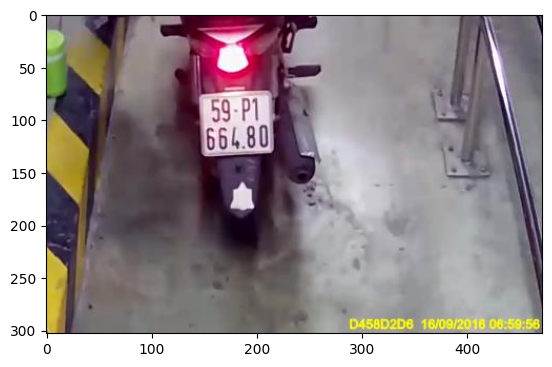

In [6]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #RGB

In [7]:
# reading 1 sample of label file
with open("/kaggle/working/datasets/GreenParking/location.txt", 'r') as fr:
    for row in fr:
        print(row)
        break

0000_00532_b.jpg 1 145 73 72 62



## Check the correctness of bounding box

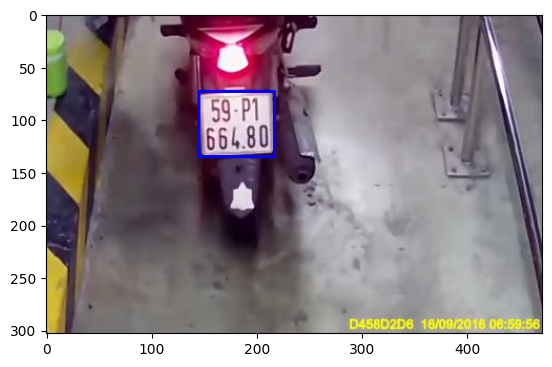

In [8]:
import cv2
color = (255, 0, 0) # BGR
rec0 = ((145,73), (145+72, 73+62))
thickness = 2
# visualie a label
img0 = cv2.imread("/kaggle/working/datasets/GreenParking/0000_00532_b.jpg")
image0 = cv2.rectangle(img0, *rec0, color, thickness)
# cv2.imshow(image0)

from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)) #RGB

## Adjust the directory structure to match the YOLO format.

In [9]:
import os
import shutil

# Chuyển đến thư mục GreenParking
os.chdir('/kaggle/working/datasets/GreenParking')

# Tạo thư mục images và labels nếu chưa tồn tại
os.makedirs('images', exist_ok=True)
os.makedirs('labels', exist_ok=True)

# Di chuyển các file ảnh (đuôi .jpg) vào thư mục images
for file in os.listdir('.'):
    if file.endswith('.jpg'):
        shutil.move(file, 'images')


In [10]:
def xyxy2yolo(x1,y1,x2,y2,img_h=303,img_w=472):
    x = round((x1 + x2)//2/img_w,6)
    y = round((y1 + y2)//2/img_h,6)
    w = round(abs(x1-x2)/img_w,6)
    h = round(abs(y1-y2)/img_h,6)
    return x,y,w,h

def xywh2yolo(x1,y1,x2,y2,img_h=303,img_w=472):
    pass

In [11]:
# 0000_00532_b.jpg 1 145 73 72 62
with open("/kaggle/working/datasets/GreenParking/location.txt", 'r') as fr:
    for row in fr:
        data = row.split()
        if len(data) != 6: continue
        file_name = data[0][:-4] # 0000_00532_b
        x1,y1,w1,h1 = [int(e) for e in data[-4:]]
        x2,y2 = x1+w1,y1+h1
        x,y,w,h = xyxy2yolo(x1,y1,x2,y2)
        with open(f"labels/{file_name}.txt", 'w') as fw:
            fw.write(f"0 {x} {y} {w} {h}")

In [12]:
from sklearn.model_selection import train_test_split
import os

labels = os.listdir("/kaggle/working/datasets/GreenParking/labels")
images = [f"{f[:-4]}.jpg" for f in labels]

train_img, test_img, train_lbl, test_lbl = train_test_split(images, labels, test_size=0.2, random_state=42)

print(train_img[:5], test_img[:5])
print(train_lbl[:5], test_lbl[:5])
print(len(train_img), len(train_lbl))
print(len(test_img), len(test_lbl))

['0325_00635_b.jpg', '0249_00586_b.jpg', '0444_08178_b.jpg', '0455_06303_b.jpg', '0111_05692_b.jpg'] ['0412_06384_b.jpg', '0257_04368_b.jpg', '0439_06699_b.jpg', '0131_00733_b.jpg', '0243_05384_b.jpg']
['0325_00635_b.txt', '0249_00586_b.txt', '0444_08178_b.txt', '0455_06303_b.txt', '0111_05692_b.txt'] ['0412_06384_b.txt', '0257_04368_b.txt', '0439_06699_b.txt', '0131_00733_b.txt', '0243_05384_b.txt']
1397 1397
350 350


In [13]:
import os
import shutil

# Tạo thư mục train, test trong images và labels
os.makedirs("/kaggle/working/datasets/GreenParking/images/train", exist_ok=True)
os.makedirs("/kaggle/working/datasets/GreenParking/images/test", exist_ok=True)
os.makedirs("/kaggle/working/datasets/GreenParking/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/datasets/GreenParking/labels/test", exist_ok=True)

# Tạo thư mục chứa ảnh nhận diện (rec_images)
os.makedirs("/kaggle/working/datasets/GreenParking/images/rec_images", exist_ok=True)

# Danh sách ảnh dùng cho giai đoạn nhận diện
rec_images = [
    '0001_05318_b.jpg', '0005_00490_b.jpg', '0007_05159_b.jpg',
    '0009_02194_b.jpg', '0009_05325_b.jpg', '0010_00004_b.jpg',
    '0012_04539_b.jpg', '0020_07156_b.jpg', '0023_05798_b.jpg',
    '0027_06458_b.jpg', '0036_00507_b.jpg'
]

# Sao chép các ảnh nhận diện vào thư mục rec_images
for f in rec_images:
    src = os.path.join("/kaggle/working/datasets/GreenParking/images", f)
    dst = os.path.join("/kaggle/working/datasets/GreenParking/images/rec_images", f)
    if os.path.exists(src):
        shutil.copy(src, dst)

# Di chuyển ảnh và nhãn vào thư mục train và test
for f in train_img:
    src = os.path.join("/kaggle/working/datasets/GreenParking/images", f)
    dst = os.path.join("/kaggle/working/datasets/GreenParking/images/train", f)
    if os.path.exists(src):
        shutil.move(src, dst)

for f in test_img:
    src = os.path.join("/kaggle/working/datasets/GreenParking/images", f)
    dst = os.path.join("/kaggle/working/datasets/GreenParking/images/test", f)
    if os.path.exists(src):
        shutil.move(src, dst)

for f in train_lbl:
    src = os.path.join("/kaggle/working/datasets/GreenParking/labels", f)
    dst = os.path.join("/kaggle/working/datasets/GreenParking/labels/train", f)
    if os.path.exists(src):
        shutil.move(src, dst)

for f in test_lbl:
    src = os.path.join("/kaggle/working/datasets/GreenParking/labels", f)
    dst = os.path.join("/kaggle/working/datasets/GreenParking/labels/test", f)
    if os.path.exists(src):
        shutil.move(src, dst)


In [14]:
! ls /kaggle/working/datasets/GreenParking/images/test | wc -l

350


In [15]:
! ls /kaggle/working/datasets/GreenParking/images/train | wc -l

1397


## Download yolov5

In [16]:
%cd /kaggle/working/
# clone yolov5
!git clone https://github.com/ultralytics/yolov5.git


/kaggle/working
Cloning into 'yolov5'...
remote: Enumerating objects: 17611, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17611 (delta 8), reused 2 (delta 2), pack-reused 17595 (from 3)
Receiving objects: 100% (17611/17611), 16.86 MiB | 30.55 MiB/s, done.
Resolving deltas: 100% (11992/11992), done.


In [17]:
%cd /kaggle/working/yolov5


!pip install -r requirements.txt --quiet


/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.8.0 requires dask==2024.8.0, but you have dask 2024.12.1 which is incompatible.


In [18]:
content = """
path: /kaggle/working/datasets/GreenParking  # dataset root dir
train: images/train  # train images (relative to 'path') 
val: images/test  # val images (relative to 'path') 
test:  # test images (optional)

# Classes
names:
  0: plate

# Download script/URL (optional)
download: https://ultralytics.com/assets/coco128.zip
"""
with open("/kaggle/working/yolov5/data/greenparking.yaml", 'w') as fw:
    fw.write(content)

# Training Detection w Yolo

In [19]:
%cd /kaggle/working/yolov5
!WANDB_MODE=disabled python train.py --img 472 --epochs 10 --data greenparking.yaml --weights yolov5s.pt --single-cls


/kaggle/working/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-10-18 10:18:28.646632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-18 10:18:28.851626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-18 10:18:28.913176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.

In [20]:
%cd /kaggle/working/yolov5
!python detect.py --img 472 --save-crop --source /kaggle/working/datasets/GreenParking/images/rec_images --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt

/kaggle/working/yolov5
detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/working/datasets/GreenParking/images/rec_images, data=data/coco128.yaml, imgsz=[472, 472], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-441-g15c0127a Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size [472, 472] must be multiple of max stride 32, updating to [480, 480]
image 1/11 /kaggle/working/datasets/GreenParking/images/rec_images/0001_05318_b.jpg: 320x480 1 plate, 27.1ms
image 2/11 /kaggle/wo

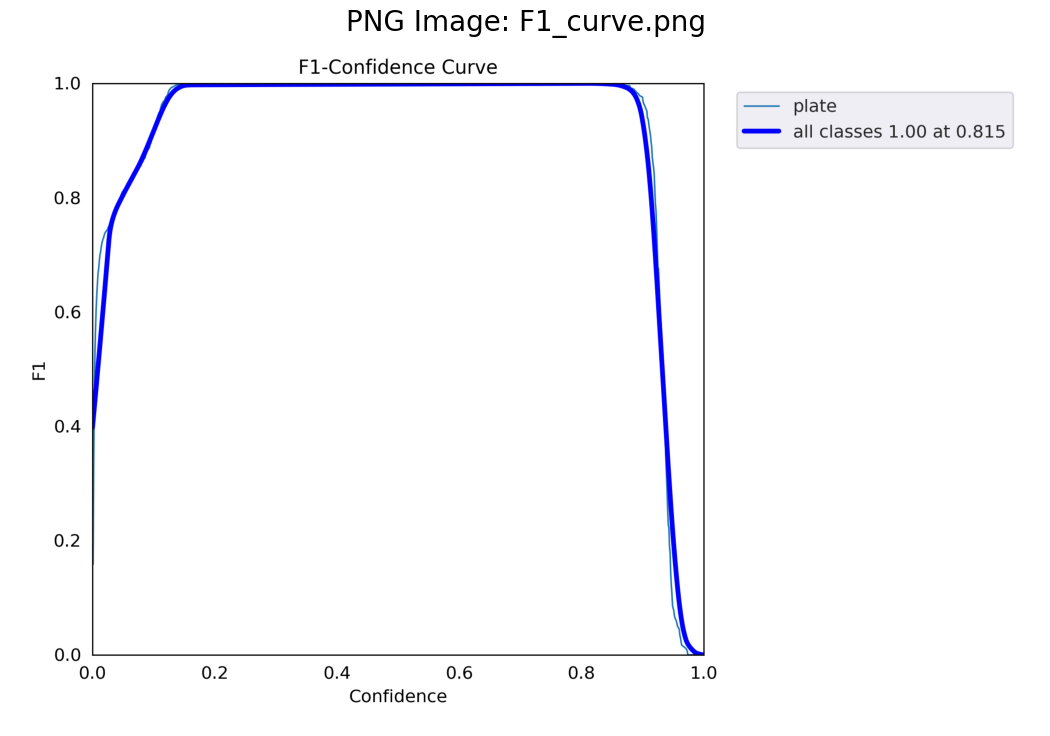

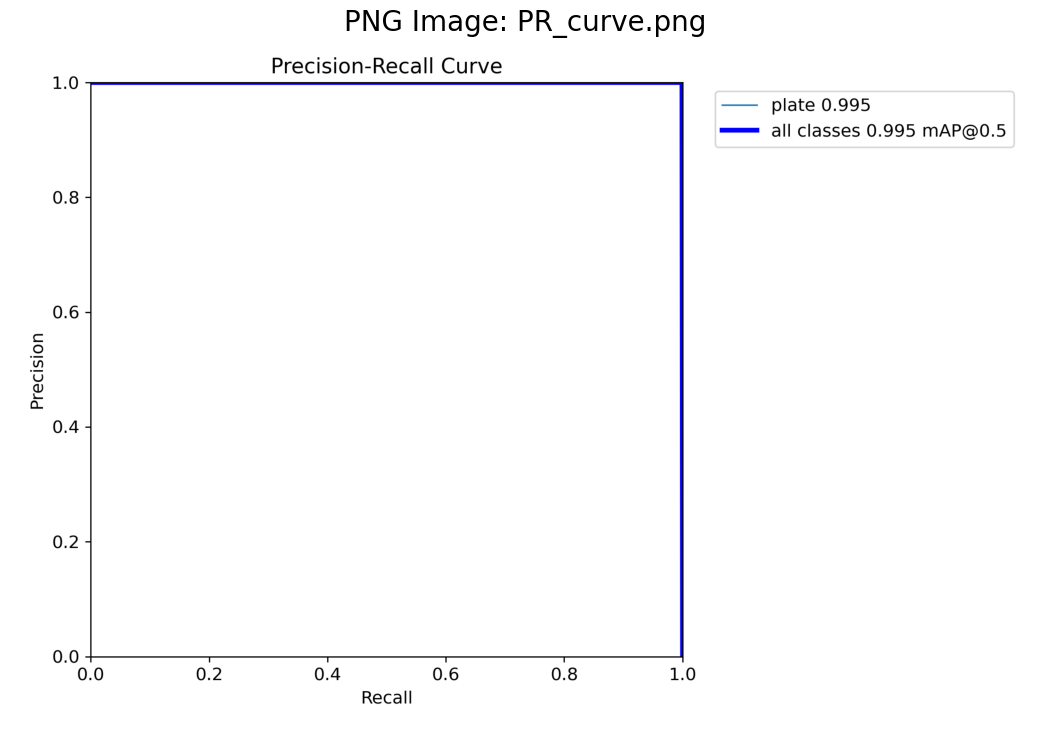

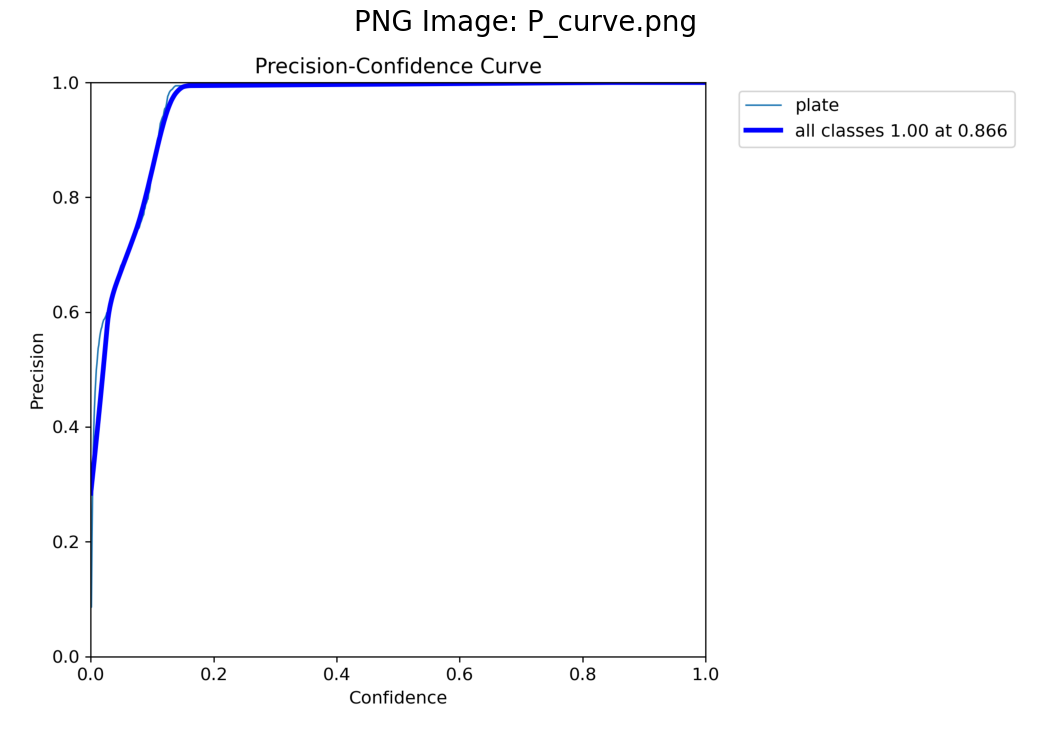

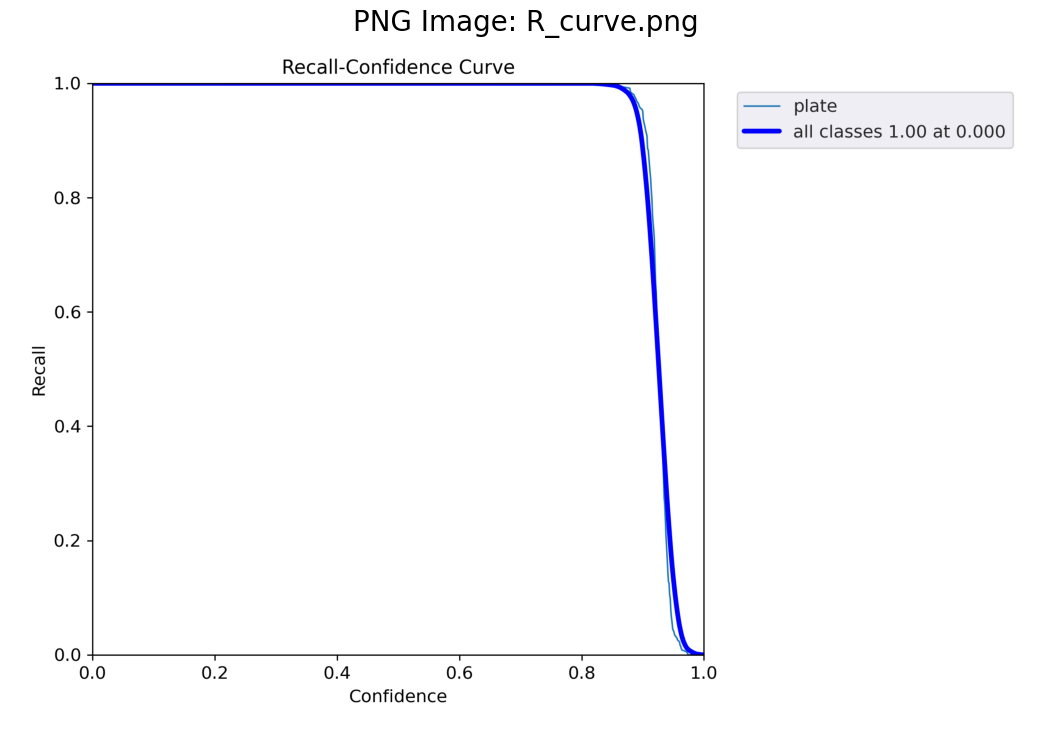

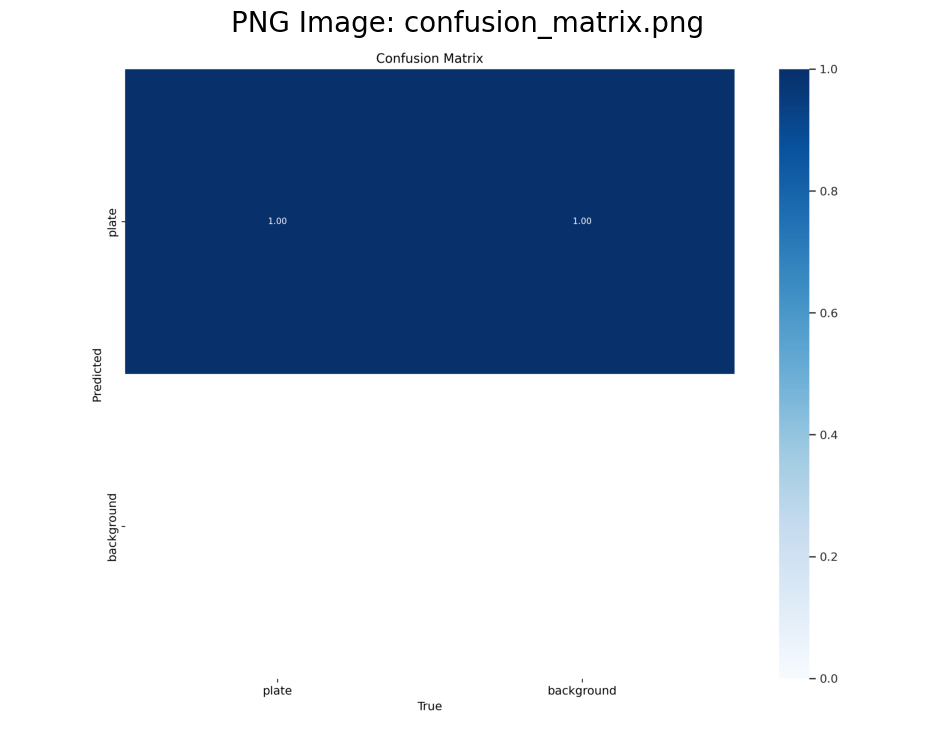

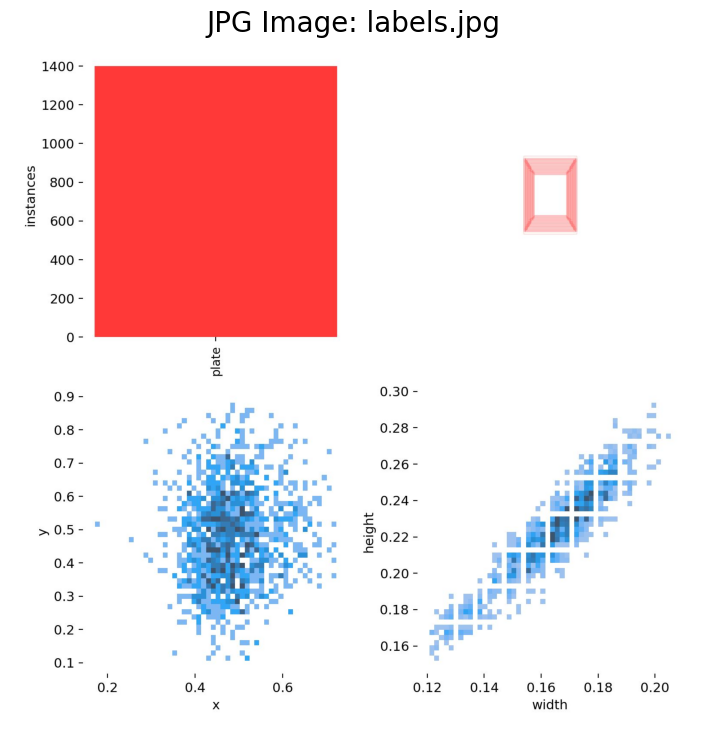

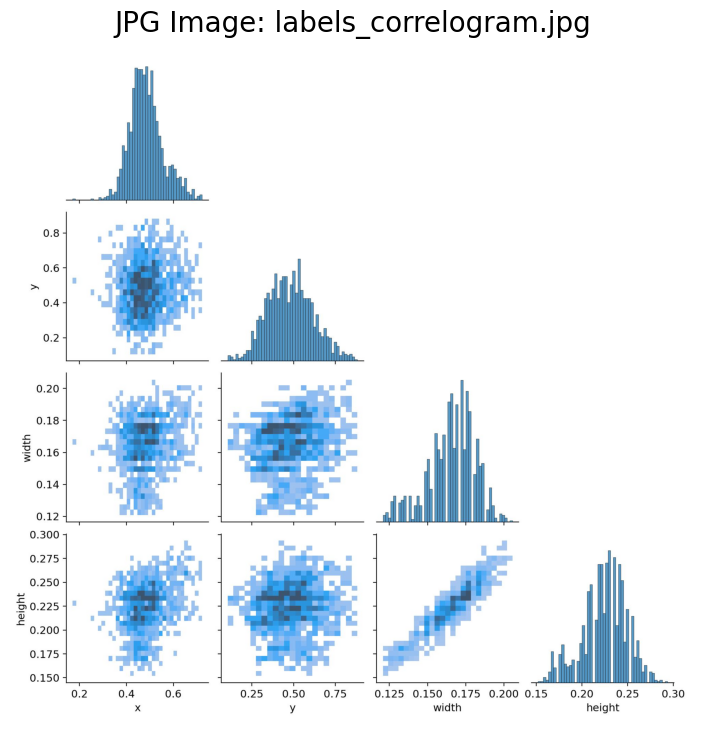

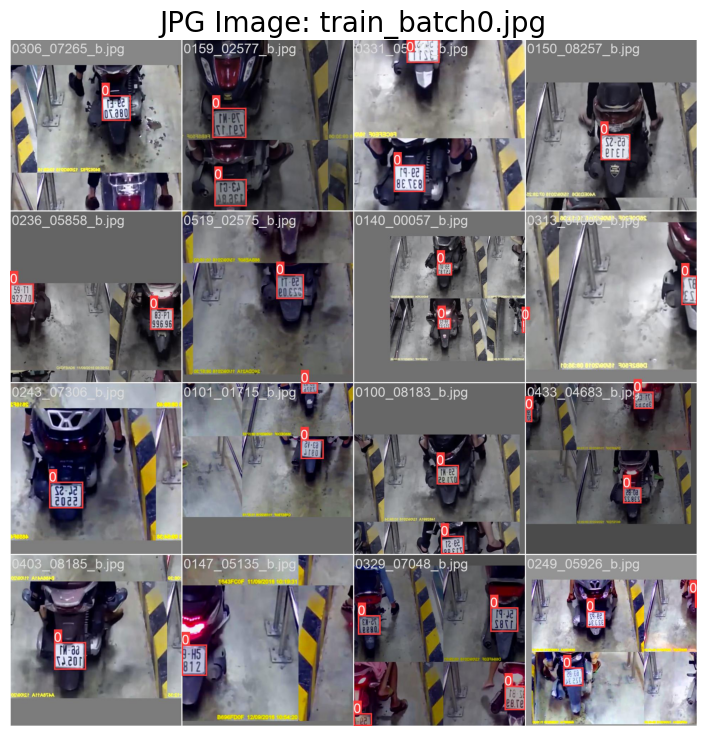

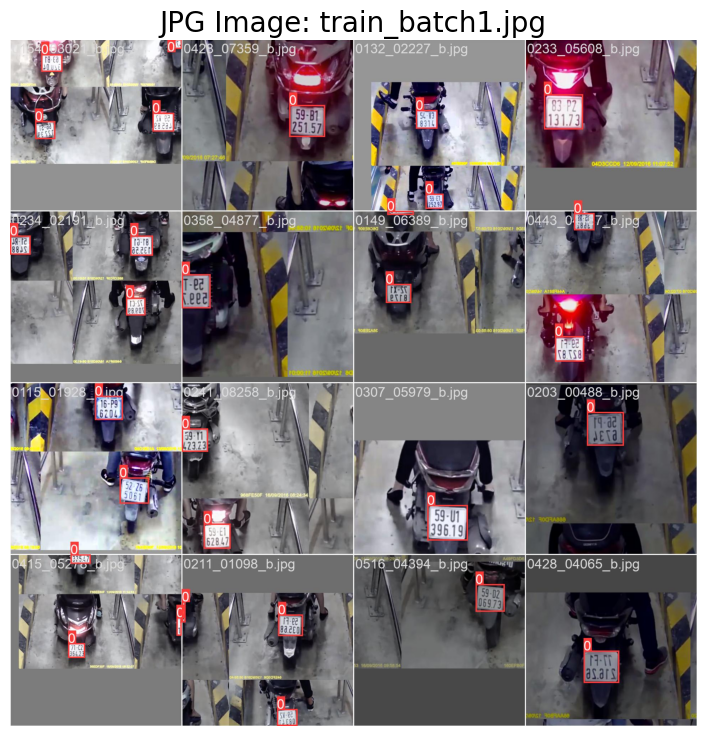

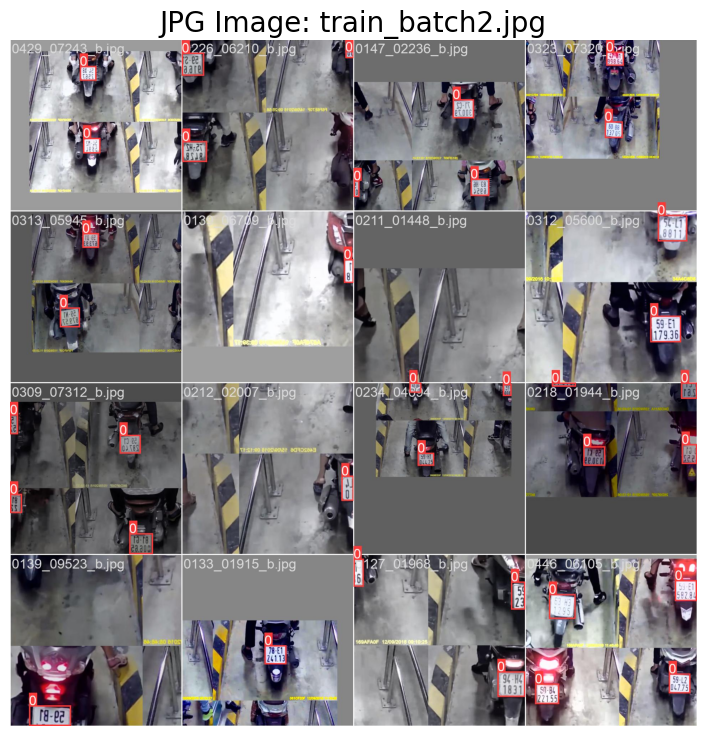

In [73]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the training results folder
train_folder = "/kaggle/working/yolov5/runs/train/exp"

# Get list of PNG and JPG images
png_images = sorted([f for f in os.listdir(train_folder) if f.lower().endswith('.png')])
jpg_images = sorted([f for f in os.listdir(train_folder) if f.lower().endswith('.jpg')])

# Function to display images with large frames and titles
def show_images(image_list, title):
    for img_name in image_list:
        img_path = os.path.join(train_folder, img_name)
        img = Image.open(img_path)

        plt.figure(figsize=(12, 8))  # Large display size for each image
        plt.imshow(img)
        plt.title(f"{title}: {img_name}", fontsize=20)  # Bigger label font
        plt.axis("off")
        plt.tight_layout(pad=3.0)
        plt.show()

# Display PNG images
if png_images:
    show_images(png_images[:5], "PNG Image")

# Display JPG images
if jpg_images:
    show_images(jpg_images[:5], "JPG Image")


# Recognition

In [21]:
plate = sorted(os.listdir("/kaggle/working/yolov5/runs/detect/exp"))
plate[:11]

['0001_05318_b.jpg',
 '0005_00490_b.jpg',
 '0007_05159_b.jpg',
 '0009_02194_b.jpg',
 '0009_05325_b.jpg',
 '0010_00004_b.jpg',
 '0012_04539_b.jpg',
 '0020_07156_b.jpg',
 '0023_05798_b.jpg',
 '0027_06458_b.jpg',
 '0036_00507_b.jpg']

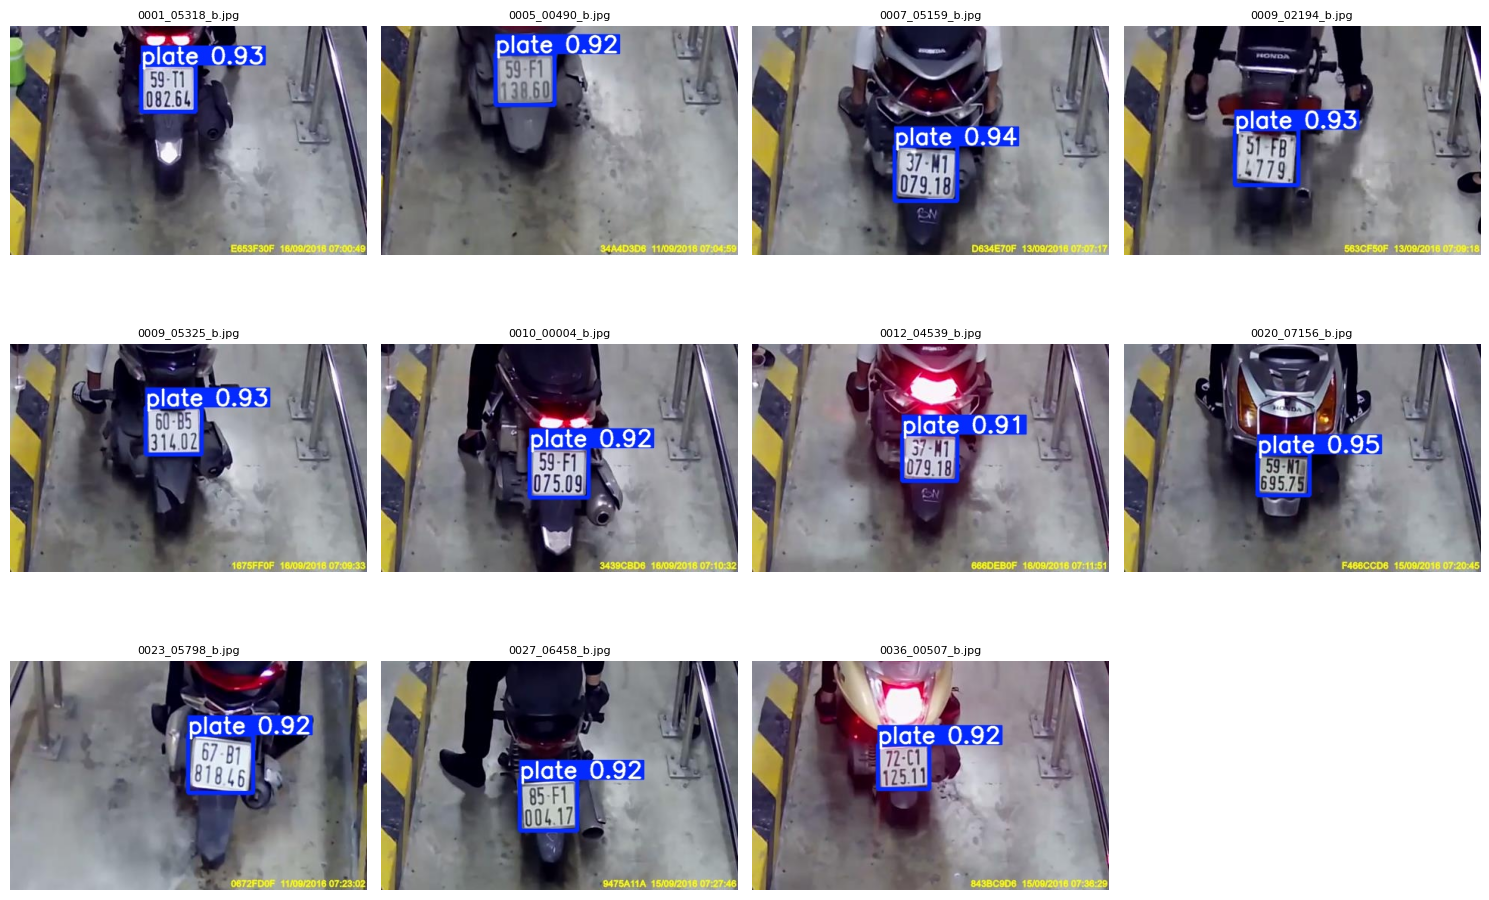

In [22]:
import os
import matplotlib.pyplot as plt
from PIL import Image


result_dir = "/kaggle/working/yolov5/runs/detect/exp"
image_files = sorted(os.listdir(result_dir))[:11]  


plt.figure(figsize=(15, 10))
for i, img_name in enumerate(image_files):
    img_path = os.path.join(result_dir, img_name)
    img = Image.open(img_path)
    
    plt.subplot(3, 4, i + 1) 
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [23]:
d = {
    '0001_05318_b': '59T108264',
    '0005_00490_b': '59F113860',
    '0007_05159_b': '37M107918',
    '0009_02194_b': '51FB4779',
    '0009_05325_b': '60B531402',
    '0010_00004_b': '59F107509',
    '0012_04539_b': '37M107918',
    '0020_07156_b': '59N169575',
    '0023_05798_b': '67B181846',
    '0027_06458_b': '85F100417',
    '0036_00507_b': '72C112511',
}

os.makedirs('/kaggle/working/datasets/recognition', exist_ok=True)


In [24]:
import shutil
crop_folder = "/kaggle/working/yolov5/runs/detect/exp/crops/plate"
reg_folder = "/kaggle/working/datasets/recognition"
crop_images = os.listdir(crop_folder)
for crop_img in crop_images:
    crop_img = crop_img.split(".")[0]
    if crop_img in d.keys():
        crop_img_path = os.path.join(crop_folder, crop_img + ".jpg")
        new_crop_path = os.path.join(reg_folder, d[crop_img] + ".jpg")
        shutil.copy(crop_img_path, new_crop_path)

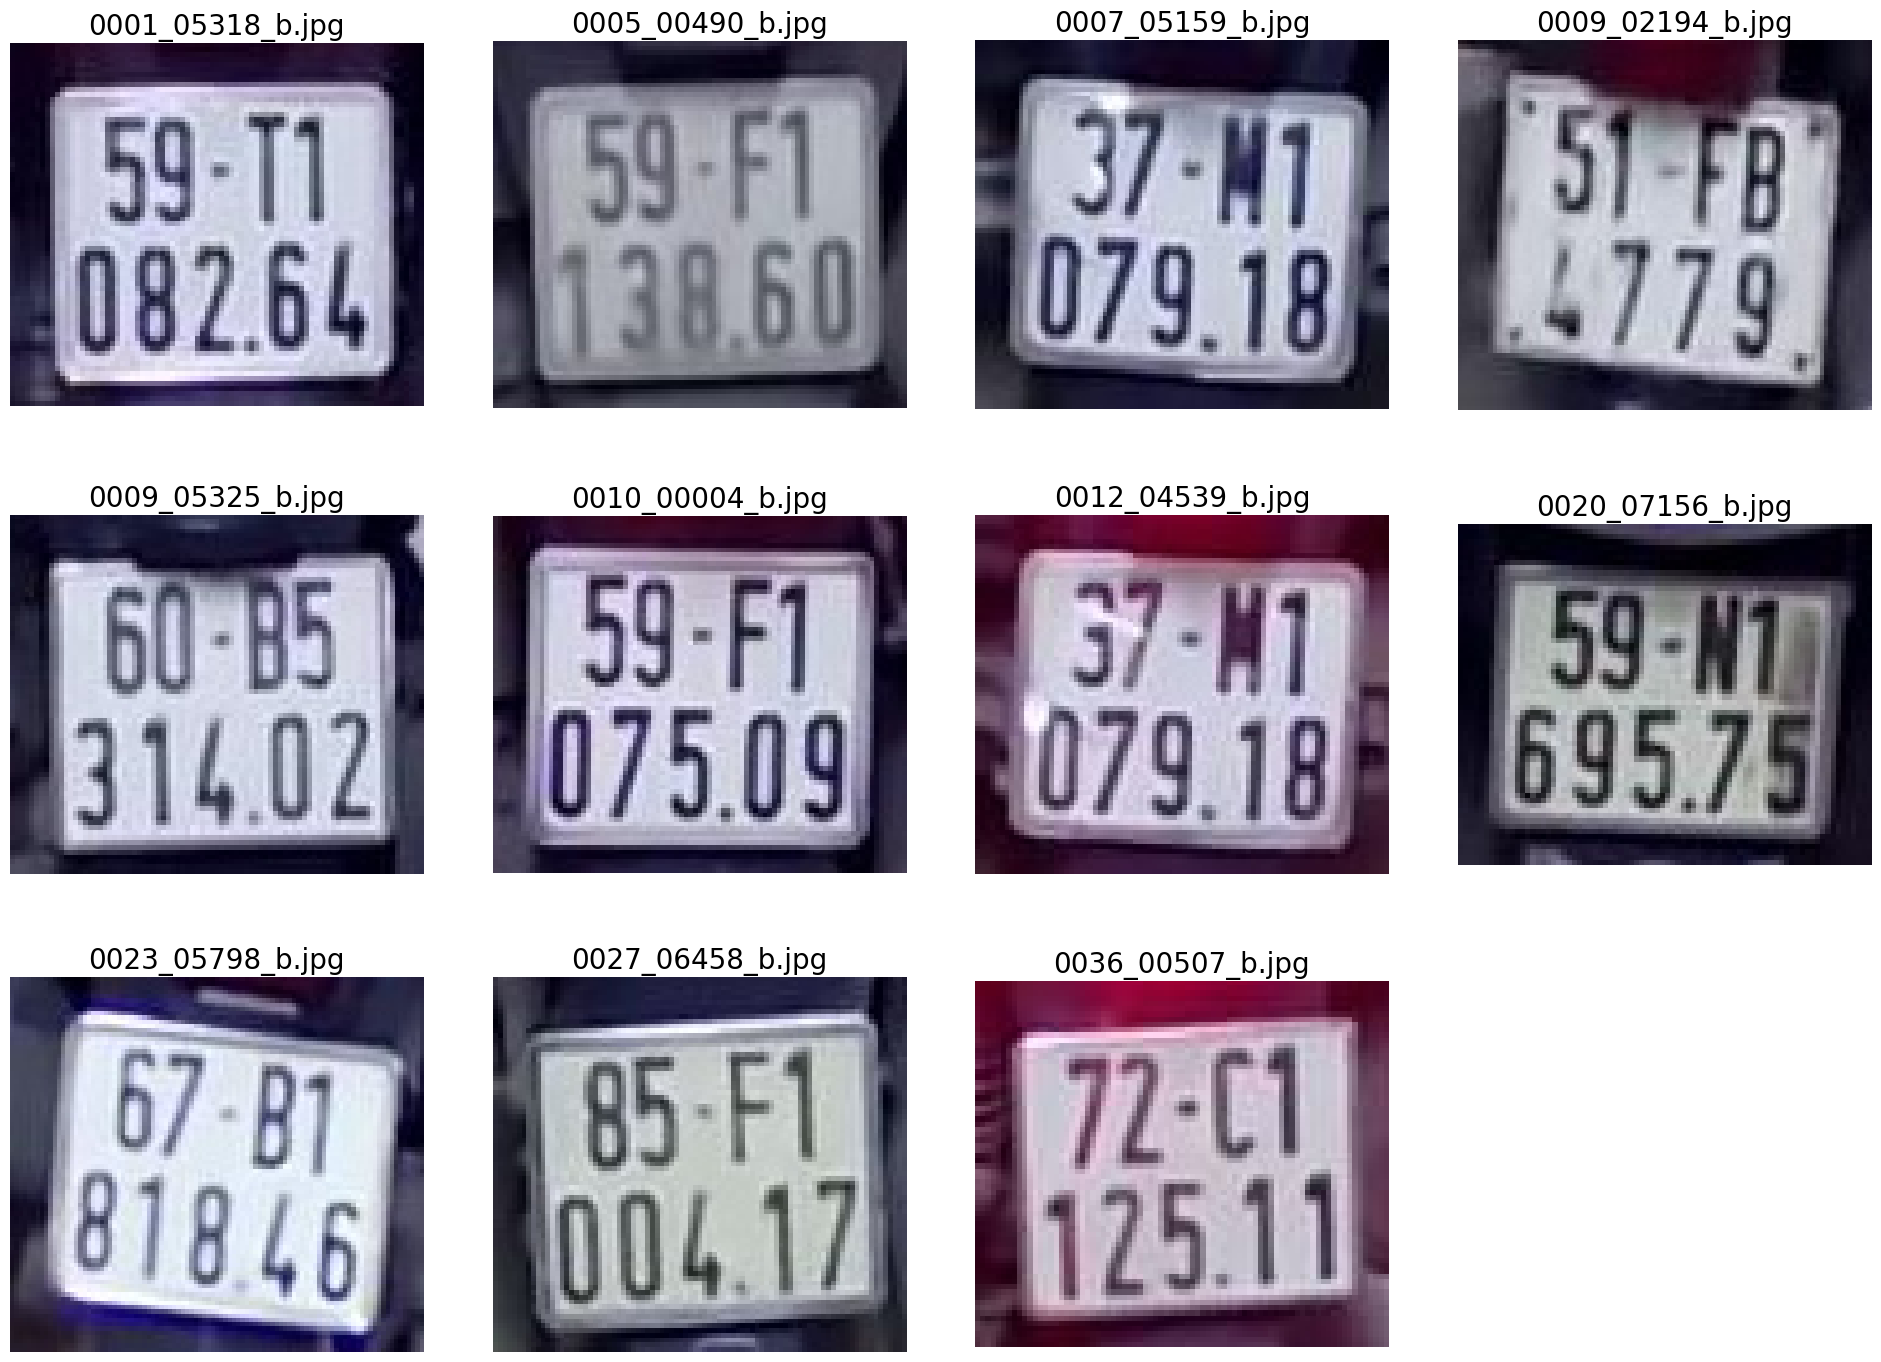

In [25]:
import os
import matplotlib.pyplot as plt
from PIL import Image

crop_folder = "/kaggle/working/yolov5/runs/detect/exp/crops/plate"
crop_images = sorted(os.listdir(crop_folder))[:12]


plt.figure(figsize=(20, 15))  

for i, img_name in enumerate(crop_images):
    img_path = os.path.join(crop_folder, img_name)
    img = Image.open(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=20)  
    plt.axis("off")

plt.tight_layout(pad=5.0)  
plt.show()


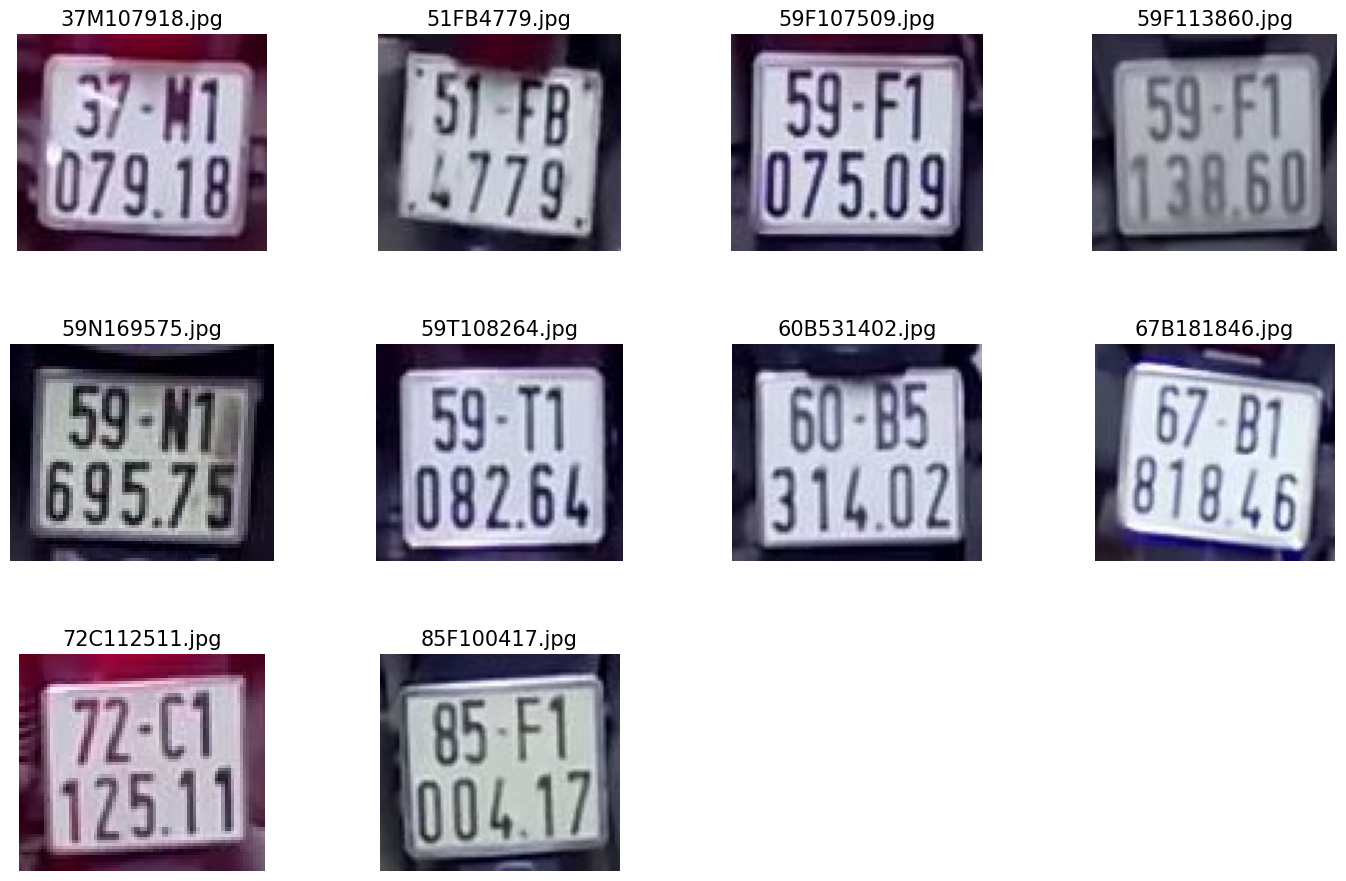

In [26]:
import os
import matplotlib.pyplot as plt
from PIL import Image

reg_folder = "/kaggle/working/datasets/recognition"
reg_images = sorted(os.listdir(reg_folder))[:12]  


plt.figure(figsize=(15, 10))
for i, img_name in enumerate(reg_images):
    img_path = os.path.join(reg_folder, img_name)
    img = Image.open(img_path)

    plt.subplot(3, 4, i + 1)  
    plt.imshow(img)
    plt.title(img_name, fontsize=15)
    plt.axis("off")

plt.tight_layout(pad=5.0)
plt.show()


# Tesseract

In [27]:
!apt-get install -qq libleptonica-dev tesseract-ocr libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/liba/libarchive/libarchive13_3.6.0-1ubuntu1.3_amd64.deb  404  Not Found [IP: 91.189.91.83 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/liba/libarchive/libarchive-dev_3.6.0-1ubuntu1.3_amd64.deb  404  Not Found [IP: 91.189.91.83 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [28]:
!pip install -q pytesseract

In [29]:
# Loading the required python modules
import pytesseract # this is tesseract module
import matplotlib.pyplot as plt
import cv2
import glob
import os

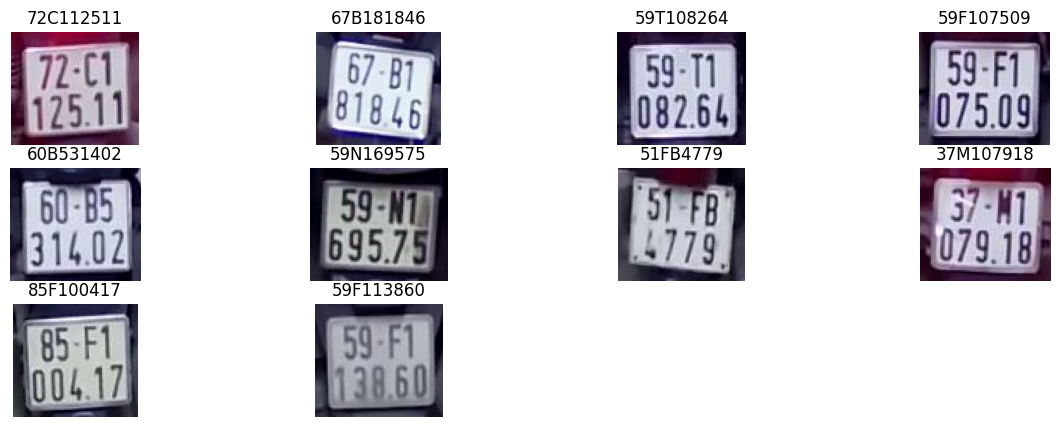

In [30]:
path_for_license_plates = "/kaggle/working/datasets/recognition"
license_plate_files = os.listdir(path_for_license_plates)
# license_plate_files.sort()

list_license_plates = []
predicted_license_plates = []

fig = plt.figure(figsize=(15, 5))

# setting values to rows and column variables
rows = 3
columns = 4

for i, license_plate_file in enumerate(license_plate_files):
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    # print(license_plate_file)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    img = cv2.imread(path_to_license_plate)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #RGB
    plt.axis('off')
    plt.title(f"{license_plate}")

    predicted_result = pytesseract.image_to_string(img, lang ='eng', config ='--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVXYZ0123456789')

    filter_predicted_result = "".join(predicted_result.split()).replace(":", "").replace("-", "")
    predicted_license_plates.append(filter_predicted_result)


In [31]:
!pip install --q jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.7 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.8.0 requires dask==2024.8.0, but you have dask 2024.12.1 which is incompatible.


In [32]:
from jiwer import cer

def calculate_predicted_accuracy(actual_list, predicted_list):
    print("Actual License Plate", "\t", "Predicted License Plate", "\t", "Accuracy")
    print("--------------------", "\t", "-----------------------", "\t", "--------")
    accs = []
    for actual_plate, predict_plate in zip(actual_list, predicted_list):
        accuracy = "0 %"
        num_matches = 0
        if actual_plate == predict_plate:
            accuracy = "100 %"
            accs.append(100)
        else:
            for a, p in zip(actual_plate, predict_plate):
                if a == p:
                    num_matches += 1
            acc = round((num_matches / len(actual_plate)), 2) * 100
            accs.append(acc)
            accuracy = str(acc) + "%"
        print("     ", actual_plate, "    \t\t", (predict_plate or "-------"), "    \t\t  ", accuracy)
    return accs

def calculate_predicted_cer(actual_list, predicted_list):
    print("Actual License Plate", "\t", "Predicted License Plate", "\t", "CER")
    print("--------------------", "\t", "-----------------------", "\t", "--------")
    errs = []
    for actual_plate, predict_plate in zip(actual_list, predicted_list):
        error = cer(actual_plate, predict_plate)
        errs.append(error)
        print("     ", actual_plate, "    \t\t", (predict_plate or "-------"), "    \t\t  ", error)
    return errs


In [33]:
from statistics import mean
accs = calculate_predicted_accuracy(list_license_plates, predicted_license_plates)
print(mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, predicted_license_plates)
print(mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 720112511     		   89.0%
      67B181846     		 67BI81846     		   89.0%
      59T108264     		 59T108264     		   100 %
      59F107509     		 59FI07509     		   89.0%
      60B531402     		 -------     		   0.0%
      59N169575     		 -------     		   0.0%
      51FB4779     		 -------     		   0.0%
      37M107918     		 377M07918     		   78.0%
      85F100417     		 85100417     		   33.0%
      59F113860     		 50F15     		   33.0%
51.1

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 720112511     		   0.1111111111111111
      67B181846     		 67BI81846     		   0.1111111111111111
      59T108264     		 59T108264     		   0.0
      59F107509     		 59FI07509     		   0.1111111111111111
      60B531402     		 -------     		   1.0
      59N169575     		 ------

In [34]:
from jiwer import cer

reference = "hello world"
hypothesis = "hello duck"

error = cer(reference, hypothesis)
print(error)

0.45454545454545453


In [35]:
import numpy as np
import imutils
from skimage.segmentation import clear_border

def img_preprocesing(img):
    masks = get_mask(img)
    return locate_license_plate(img, masks)
    # return locate_license_plate(img, masks)

def get_mask(img, keep=5):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # ret,thresh
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Find the black points
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 5))
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, rectKern)

    # closing the object
    squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    light = cv2.morphologyEx(img, cv2.MORPH_CLOSE, squareKern)
    light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # find the region of plate
    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
            dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
    gradX = gradX.astype("uint8")

    gradX = cv2.GaussianBlur(gradX, (21, 21), 0)
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
    # kernele = np.array([[1,1,1],[1,1,1],[1,1,1]], np.uint8)
    kernele = np.ones((5,5))
    kerneld = np.array([[0,0,0,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,0,0,0]], np.uint8)
    # kernele = kerneld = np.ones((3,3))
    # print(kernele)
    # kernel = np.ones((3,3))
    # print(kernel)

    thresh0 = cv2.erode(gradX, kernele, iterations=2)
    thresh1 = cv2.dilate(gradX, kerneld, iterations=2)

    thresh = cv2.bitwise_and(thresh0, thresh1, mask=light)
    thresh = cv2.dilate(thresh, kerneld, iterations=2)
    thresh = cv2.erode(thresh, kernele, iterations=1)
    # print("thresh")
    # cv2_imshow(thresh)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE) # contours, hierarchy
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]

    return cnts

def locate_license_plate(img, candidates, clearBorder=False):
    minAR, maxAR = 0,5
    # initialize the license plate contour and ROI
    lpCnt = None
    roi = None
    # loop over the license plate candidate contours
    rois = []
    for c in candidates:
        # compute the bounding box of the contour and then use
        # the bounding box to derive the aspect ratio
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)

        if ar >= minAR and ar <= maxAR:
            # store the license plate contour and extract the
            # license plate from the grayscale image and then
            # threshold it
            lpCnt = c
            licensePlate = img[y:y + h, x:x + w]

            # ## scale img
            scale_percent = 150 # percent of original size
            width = int(licensePlate.shape[1] * scale_percent / 100)
            height = int(licensePlate.shape[0] * scale_percent / 100)
            licensePlate = cv2.resize(licensePlate, (width, height), interpolation = cv2.INTER_CUBIC)

            break
    return licensePlate

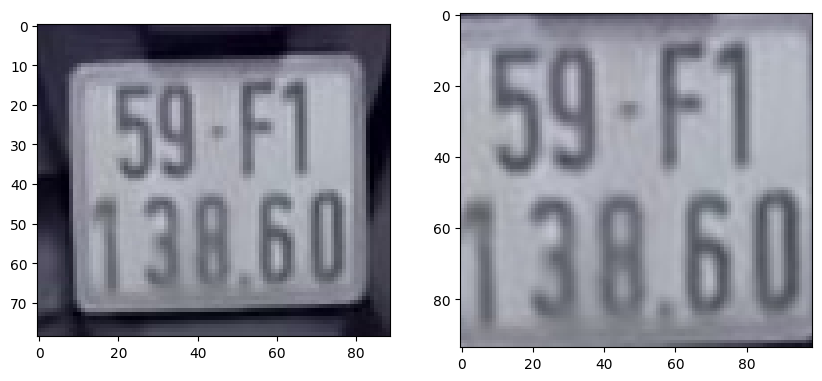

In [36]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
img = cv2.imread("/kaggle/working/datasets/recognition/59F113860.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #RGB

fig.add_subplot(1, 2, 2)
img = img_preprocesing(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #RGB


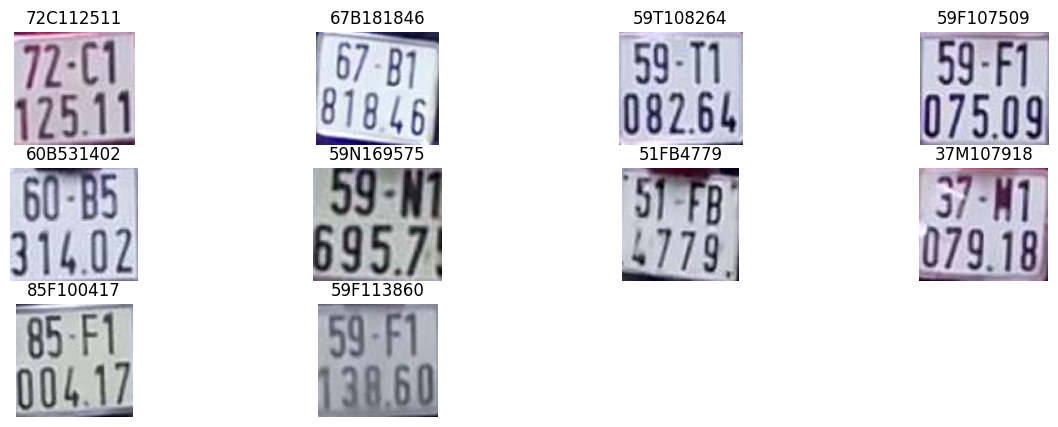

In [37]:
path_for_license_plates = "/kaggle/working/datasets/recognition"
license_plate_files = [f for f in os.listdir(path_for_license_plates) if f[-4:]==".jpg"]
# license_plate_files.sort()
list_license_plates = []
predicted_license_plates = []

fig = plt.figure(figsize=(15, 5))

# setting values to rows and column variables
rows = 3
columns = 4

for i, license_plate_file in enumerate(license_plate_files):
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    # print(license_plate_file)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    img = cv2.imread(path_to_license_plate)
    img = img_preprocesing(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #RGB
    plt.axis('off')
    plt.title(f"{license_plate}")

    predicted_result = pytesseract.image_to_string(img, lang ='eng', config ='--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVXYZ0123456789')

    filter_predicted_result = "".join(predicted_result.split()).replace(":", "").replace("-", "")
    predicted_license_plates.append(filter_predicted_result)

In [38]:
accs = calculate_predicted_accuracy(list_license_plates, predicted_license_plates)
print(mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, predicted_license_plates)
print(mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 7012511     		   11.0%
      67B181846     		 678181846     		   89.0%
      59T108264     		 59T108264     		   100 %
      59F107509     		 59FT07509     		   89.0%
      60B531402     		 60B531402     		   100 %
      59N169575     		 99H6957     		   11.0%
      51FB4779     		 TTR4779     		   12.0%
      37M107918     		 AT07918     		   0.0%
      85F100417     		 BFL00417     		   11.0%
      59F113860     		 59FT13860     		   89.0%
51.2

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 7012511     		   0.3333333333333333
      67B181846     		 678181846     		   0.1111111111111111
      59T108264     		 59T108264     		   0.0
      59F107509     		 59FT07509     		   0.1111111111111111
      60B531402     		 60B531402     		   0.0
      59N169575     		 99

## ------- start test

## rotate plate

In [39]:
import numpy as np
import math
import cv2

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def compute_skew(src_img):

    if len(src_img.shape) == 3:
        h, w, _ = src_img.shape
    elif len(src_img.shape) == 2:
        h, w = src_img.shape
    else:
        print('upsupported image type')

    img = cv2.medianBlur(src_img, 3)

    edges = cv2.Canny(img,  threshold1 = 50,  threshold2 = 170, apertureSize = 3, L2gradient = True)
    ## ss added
    edges = edges[55:,:]
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 4.0, maxLineGap=h/4.0)
    angle = 0.0
    nlines = lines.size

    #print(nlines)
    cnt = 0
    for x1, y1, x2, y2 in lines[0]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        #print(ang)
        if math.fabs(ang) <= 30/180*math.pi: # excluding extreme rotations
            if ang < 0:
                angle += ang
            else:
                angle += ang
            cnt += 1

    if cnt == 0:
        return 0.0
    return (angle / cnt)*180/math.pi

def deskew(src_img):
    return rotate_image(src_img, compute_skew(src_img))


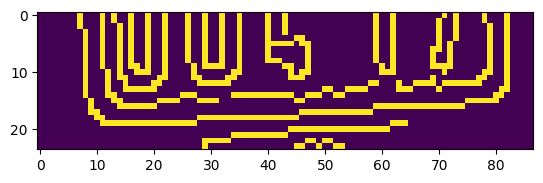

[[[12 19 74 16]]

 [[ 9 17 82 12]]]
8
-0.04834938665190288
-2.7702157972001933
-0.04834938665190288


In [40]:
#### testing skew
# src_img = cv2.imread('/kaggle/working/datasets/recognition/51FB4779.jpg')
src_img = cv2.imread("/kaggle/working/datasets/recognition/85F100417.jpg")
# src_img = cv2.imread("/kaggle/working/datasets/recognition/72C112511.jpg")

if len(src_img.shape) == 3:
    h, w, _ = src_img.shape
elif len(src_img.shape) == 2:
    h, w = src_img.shape
else:
    print('upsupported image type')

img = cv2.medianBlur(src_img, 3)
cutted_img = img[55:,:]
edges = cv2.Canny(cutted_img,  threshold1 = 50,  threshold2 = 170, apertureSize = 3, L2gradient = True)
lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 4.0, maxLineGap=h/4.0)

imgplot = plt.imshow(edges)
plt.show()
angle = 0.0
nlines = lines.size

print(lines)
print(nlines)
cnt = 0
for x1, y1, x2, y2 in lines[0]:
    ang = np.arctan2(y2 - y1, x2 - x1)
    print(ang)
    print(ang/math.pi*180)
    if math.fabs(ang) <= 30/180*math.pi: # excluding extreme rotations
        angle += ang
        cnt += 1
print(angle)

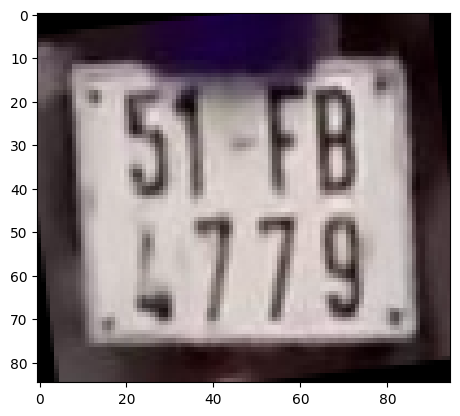

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# img = mpimg.imread('your_image.png')

img = cv2.imread('/kaggle/working/datasets/recognition/51FB4779.jpg')
corrected_img = deskew(img)

imgplot = plt.imshow(corrected_img)
plt.show()

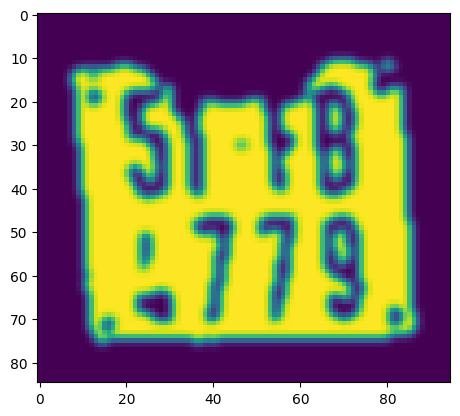

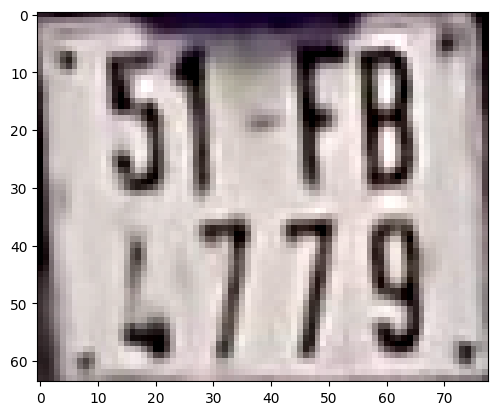

In [42]:
oimg = cv2.imread('/kaggle/working/datasets/recognition/51FB4779.jpg')
# oimg = cv2.imread('/kaggle/working/datasets/recognition/37M107918.jpg')
# oimg = cv2.imread('/kaggle/working/datasets/recognition/59N169575.jpg')


img = deskew(oimg)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY) # ret,thresh
img = cv2.GaussianBlur(img, (5, 5), 0)

imgplot = plt.imshow(img)
plt.show()

# Find the black points
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 5))
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, rectKern)

# closing the object
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(img, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

rows, cols = np.where(light == 255)

# Get the bounds of the rectangle
top, bottom = rows.min(), rows.max()
left, right = cols.min(), cols.max()

cropped = img[top:bottom, left:right]
colored = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)

dimg = deskew(oimg)[top:bottom, left:right]

blurred = cv2.GaussianBlur(dimg, (9, 9), 10.0)
sharpened_image = cv2.addWeighted(dimg, 1.5, blurred, -0.5, 0)

imgplot = plt.imshow(sharpened_image)
plt.show()

# find the region of plate
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
        dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")

gradX = cv2.GaussianBlur(gradX, (21, 21), 0)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)

# kernele = np.array([[1,1,1],[1,1,1],[1,1,1]], np.uint8)
kernele = np.ones((5,5))
kerneld = np.array([[0,0,0,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,0,0,0]], np.uint8)
# kernele = kerneld = np.ones((3,3))
# print(kernele)
# kernel = np.ones((3,3))
# print(kernel)

thresh0 = cv2.erode(gradX, kernele, iterations=2)
thresh1 = cv2.dilate(gradX, kerneld, iterations=2)

thresh = cv2.bitwise_and(thresh0, thresh1, mask=light)
thresh = cv2.dilate(thresh, kerneld, iterations=2)
thresh = cv2.erode(thresh, kernele, iterations=1)

In [43]:
def preprocess_v2(oimg):
    dimg = deskew(oimg)
    img = cv2.cvtColor(dimg, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY) # ret,thresh
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Find the black points
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 5))
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, rectKern)

    # closing the object
    squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    light = cv2.morphologyEx(img, cv2.MORPH_CLOSE, squareKern)
    light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    rows, cols = np.where(light == 255)

    # Get the bounds of the rectangle
    top, bottom = rows.min(), rows.max()
    left, right = cols.min(), cols.max()

    # return deskew(oimg)[top:bottom, left:right]
    cropped = dimg[top:bottom, left:right]
    blurred = cv2.GaussianBlur(cropped, (9, 9), 10.0)
    sharpened_image = cv2.addWeighted(cropped, 1.5, blurred, -0.5, 0)
    return sharpened_image


In [44]:
def preprocess_v3(oimg):
    dimg = deskew(oimg)
    img = cv2.cvtColor(dimg, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY) # ret,thresh
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Find the black points
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 5))
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, rectKern)

    # closing the object
    squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    light = cv2.morphologyEx(img, cv2.MORPH_CLOSE, squareKern)
    light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    rows, cols = np.where(light == 255)

    # Get the bounds of the rectangle
    top, bottom = rows.min(), rows.max()
    left, right = cols.min(), cols.max()

    # return deskew(oimg)[top:bottom, left:right]
    cropped = dimg[top:bottom, left:right]
    # blurred = cv2.GaussianBlur(cropped, (9, 9), 10.0)
    # sharpened_image = cv2.addWeighted(cropped, 1.5, blurred, -0.5, 0)

    # reprocess v2 to bolder blur things
    img = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    median_val = np.median(img.reshape(-1,), axis=0)
    mean_val = np.mean(img.reshape(-1,), axis=0)
    _, img = cv2.threshold(img, (median_val+mean_val)/2, 255, cv2.THRESH_BINARY) # ret,thresh
    img = cv2.GaussianBlur(img, (7, 7), 0)

    recolor = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    sharpened_image2 = cv2.addWeighted(cropped, .5, recolor, .5, 0)
    for i in range(3, 10, 2):
        blurred = cv2.GaussianBlur(sharpened_image2, (i, i), 1)
        sharpened_image2 = cv2.addWeighted(sharpened_image2, 1.5, blurred, -0.5, 0)
    return sharpened_image2


## test erode, dilate

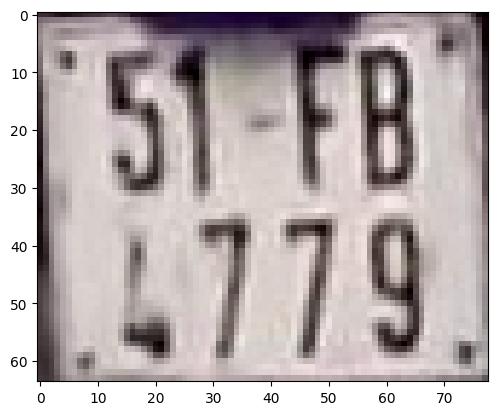

In [45]:
oimg = cv2.imread('/kaggle/working/datasets/recognition/51FB4779.jpg')
# oimg = cv2.imread('/kaggle/working/datasets/recognition/37M107918.jpg')
# oimg = cv2.imread('/kaggle/working/datasets/recognition/59N169575.jpg')


img = deskew(oimg)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY) # ret,thresh
img = cv2.GaussianBlur(img, (5, 5), 0)

# Find the black points
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 5))
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, rectKern)

# closing the object
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(img, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

rows, cols = np.where(light == 255)

# Get the bounds of the rectangle
top, bottom = rows.min(), rows.max()
left, right = cols.min(), cols.max()

cropped = img[top:bottom, left:right]
colored = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)

dimg = deskew(oimg)[top:bottom, left:right]
# imgplot = plt.imshow(dimg)
# plt.show()

blurred = cv2.GaussianBlur(dimg, (5, 5), 1)
# imgplot = plt.imshow(blurred)
# plt.show()

sharpened_image = cv2.addWeighted(dimg, 1.5, blurred, -0.5, 0)
imgplot = plt.imshow(sharpened_image)
plt.show()

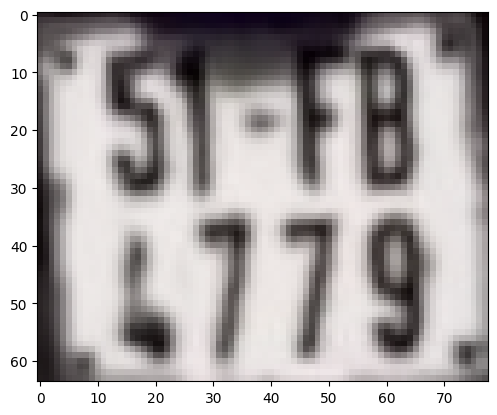

In [46]:
import numpy as np
### round the image value to clear points, greate img, but seems not good for reg
img = cv2.cvtColor(dimg, cv2.COLOR_BGR2GRAY)
median_val = np.median(img.reshape(-1,), axis=0)
mean_val = np.mean(img.reshape(-1,), axis=0)
_, img = cv2.threshold(img, (median_val+mean_val)/2, 255, cv2.THRESH_BINARY) # ret,thresh
img = cv2.GaussianBlur(img, (7, 7), 0)

recolor = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

sharpened_image2 = cv2.addWeighted(dimg, 0.5, recolor, 0.5, 0)
imgplot = plt.imshow(sharpened_image2)
plt.show()


### normal hardeness
# blur1 = cv2.GaussianBlur(dimg, (5, 5), 0)
# blur2 = cv2.GaussianBlur(dimg, (7, 7), 0)
# blur3 = cv2.GaussianBlur(dimg, (9, 9), 0)
# blur4 = cv2.GaussianBlur(dimg, (11, 11), 0)

# sharpened_image2 = cv2.addWeighted(dimg, 1.5, blur4, -0.5, 0)
# imgplot = plt.imshow(sharpened_image2)
# plt.show()

# sharpened_image2 = cv2.addWeighted(sharpened_image2, 1.5, blur3, -0.5, 0)
# imgplot = plt.imshow(sharpened_image2)
# plt.show()

# sharpened_image2 = cv2.addWeighted(sharpened_image2, 1.5, blur2, -0.5, 0)
# imgplot = plt.imshow(sharpened_image2)
# plt.show()

# sharpened_image2 = cv2.addWeighted(sharpened_image2, 1.5, blur1, -0.5, 0)
# imgplot = plt.imshow(sharpened_image2)
# plt.show()

# # Convert images to float to prevent overflow during summation
# blur1 = blur1.astype(np.float32)
# blur2 = blur2.astype(np.float32)
# blur3 = blur3.astype(np.float32)
# blur4 = blur4.astype(np.float32)
# # Sum the images
# average_blur = (blur1 + blur2 + blur3 + blur4) / 4
# average_blur = np.clip(average_blur, 0, 255).astype(np.uint8)

# sharpened_image3 = cv2.addWeighted(dimg, 1.5, average_blur, -0.5, 0)
# imgplot = plt.imshow(sharpened_image3)
# plt.show()

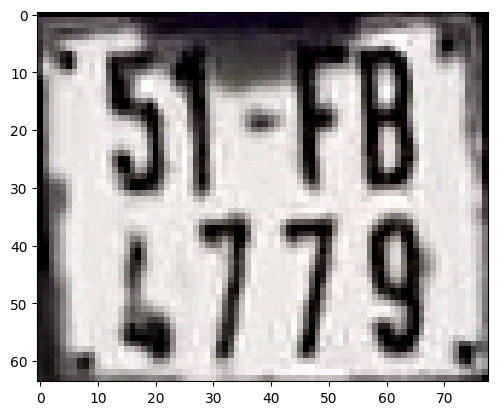

In [47]:
sharpened_image2 = cv2.addWeighted(dimg, 0.5, recolor, 0.5, 0)
for i in range(3, 10, 2):
    blurred = cv2.GaussianBlur(sharpened_image2, (i, i), 1)
    sharpened_image2 = cv2.addWeighted(sharpened_image2, 1.5, blurred, -0.5, 0)

imgplot = plt.imshow(sharpened_image2)
plt.show()

## ------- end test

72C112511
67B181846
59T108264
59F107509
60B531402
59N169575
51FB4779
37M107918
85F100417
59F113860


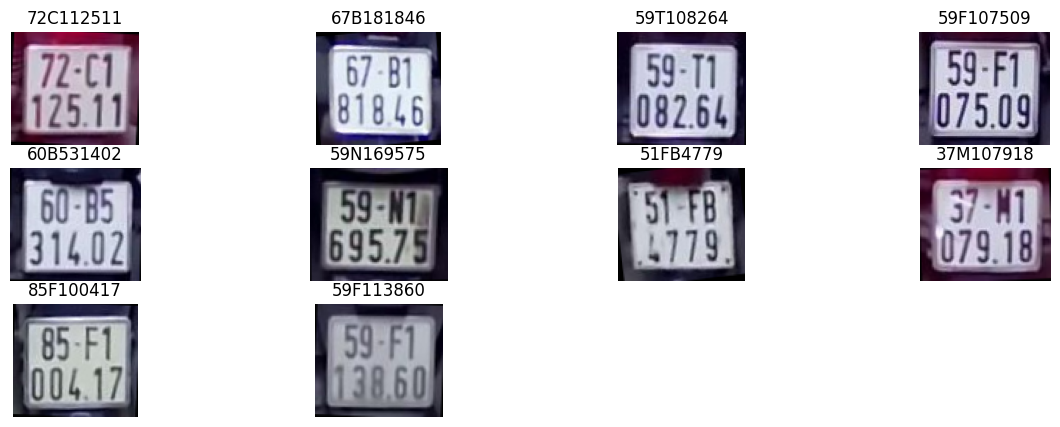

In [48]:
path_for_license_plates = "/kaggle/working/datasets/recognition"
license_plate_files = [f for f in os.listdir(path_for_license_plates) if f[-4:]==".jpg"]
# license_plate_files.sort()
list_license_plates = []
predicted_license_plates = []

fig = plt.figure(figsize=(15, 5))

# setting values to rows and column variables
rows = 3
columns = 4

for i, license_plate_file in enumerate(license_plate_files):
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    # print(license_plate_file)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    print(license_plate)
    img = cv2.imread(path_to_license_plate)
    img = deskew(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #RGB
    plt.axis('off')
    plt.title(f"{license_plate}")

    predicted_result = pytesseract.image_to_string(img, lang ='eng', config ='--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVXYZ0123456789')

    filter_predicted_result = "".join(predicted_result.split()).replace(":", "").replace("-", "")
    predicted_license_plates.append(filter_predicted_result)

In [49]:
accs = calculate_predicted_accuracy(list_license_plates, predicted_license_plates)
print(np.mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, predicted_license_plates)
print(np.mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 720112511     		   89.0%
      67B181846     		 67B181846     		   100 %
      59T108264     		 39T108264     		   89.0%
      59F107509     		 59FI07509     		   89.0%
      60B531402     		 31402     		   0.0%
      59N169575     		 69575     		   11.0%
      51FB4779     		 -------     		   0.0%
      37M107918     		 37K107918     		   89.0%
      85F100417     		 85F1100417     		   56.00000000000001%
      59F113860     		 -------     		   0.0%
52.3

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 720112511     		   0.1111111111111111
      67B181846     		 67B181846     		   0.0
      59T108264     		 39T108264     		   0.1111111111111111
      59F107509     		 59FI07509     		   0.1111111111111111
      60B531402     		 31402     		   0.4444444444444444
   

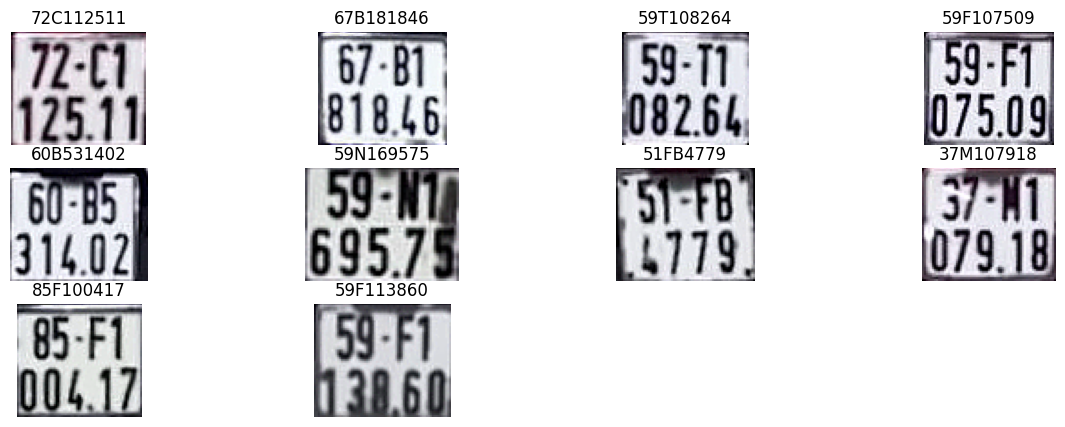

In [50]:
path_for_license_plates = "/kaggle/working/datasets/recognition"
license_plate_files = [f for f in os.listdir(path_for_license_plates) if f[-4:]==".jpg"]
# license_plate_files.sort()
list_license_plates = []
predicted_license_plates = []

fig = plt.figure(figsize=(15, 5))

# setting values to rows and column variables
rows = 3
columns = 4

for i, license_plate_file in enumerate(license_plate_files):
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    # print(license_plate_file)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    img = cv2.imread(path_to_license_plate)
    img = preprocess_v3(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #RGB
    plt.axis('off')
    plt.title(f"{license_plate}")

    predicted_result = pytesseract.image_to_string(img, lang ='eng', config ='--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVXYZ0123456789')

    filter_predicted_result = "".join(predicted_result.split()).replace(":", "").replace("-", "")
    predicted_license_plates.append(filter_predicted_result)

In [51]:
accs = calculate_predicted_accuracy(list_license_plates, predicted_license_plates)
print(np.mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, predicted_license_plates)
print(np.mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 720117511     		   78.0%
      67B181846     		 67B181846     		   100 %
      59T108264     		 591108264     		   89.0%
      59F107509     		 -------     		   0.0%
      60B531402     		 603531402     		   89.0%
      59N169575     		 STT     		   0.0%
      51FB4779     		 -------     		   0.0%
      37M107918     		 -------     		   0.0%
      85F100417     		 C     		   0.0%
      59F113860     		 P     		   0.0%
35.6

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 720117511     		   0.2222222222222222
      67B181846     		 67B181846     		   0.0
      59T108264     		 591108264     		   0.1111111111111111
      59F107509     		 -------     		   1.0
      60B531402     		 603531402     		   0.1111111111111111
      59N169575     		 STT     		   1.0
      51F

# Easy OCR

In [52]:
!pip install easyocr --quiet

In [53]:
import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

In [54]:
list_results = []
list_license_plates = []
for license_plate_file in license_plate_files:
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    print(license_plate)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # img = cv2.imread(path_to_license_plate, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(path_to_license_plate)
    img = img_preprocesing(img)
    result = reader.readtext(img, detail=0)
    list_results.append(result)
    print(result)

72C112511
['72-C1', '125.11']
67B181846
['67.B7', '810 46']
59T108264
['59-T1', '082.64']
59F107509
['59-F1', '075.09']
60B531402
['60*85', '314.02']
59N169575
['59-N1', '695.7 .']
51FB4779
['51FB', '4179 ,']
37M107918
['37*K1', '079.18']
85F100417
['85 FI', '00L.1Z']
59F113860
['59 FI', '130.60']


In [55]:
import re
def remove_symbols(result):
    # remove connected symbols
    return re.sub(r'[^a-zA-Z\d]', '', result)

In [56]:
for rs in list_results:
    for i in range(2):
        rs[i] = remove_symbols(rs[i])
for rs in list_results:
    print(rs)

['72C1', '12511']
['67B7', '81046']
['59T1', '08264']
['59F1', '07509']
['6085', '31402']
['59N1', '6957']
['51FB', '4179']
['37K1', '07918']
['85FI', '00L1Z']
['59FI', '13060']


In [57]:
# , detection='DB', recognition = 'Transformer'

### post processing

import string

dict_char_to_int = {'O': '0',
                    'L': '4',
                    'B': '8',
                    'I': '1',
                    'T': '1',
                    'J': '3',
                    'A': '4',
                    'G': '6',
                    'Z': '2',
                    'S': '5'}

dict_int_to_char = {'0': 'C',
                    '1': 'T',
                    '4': 'A',
                    '6': 'G',
                    '2': 'Z',
                    '5': 'S',
                    '8': 'B'}

def post_process(list_results, letter_idx=2):
    predict_results = []
    for result in list_results: # [['37MI', '07918'],...]
        # check if true format upper row
        if len(result[0]) > letter_idx:
            letter = result[0][letter_idx]
            if letter in dict_int_to_char.keys():
                result[0] = result[0][:2] + dict_int_to_char[letter] + result[0][3:]

        for i in range(3): # cause 4th letter could be a charater (50cc)
            if i != letter_idx:
                if i<len(result[0]):
                    number = result[0][i]
                    if number in dict_char_to_int.keys():
                        result[0] = result[0][:i] + dict_char_to_int[number] + result[0][i+1:]

        ## anyway, if the 4th=='I' convert it to '1'
        if len(result[0]) >= 4:
            char_var = result[0][3]
            if char_var not in ["A", "B"]:
                if char_var in dict_char_to_int.keys():
                    result[0] = result[0][:3] + dict_char_to_int[char_var]

        # check if true format upper row
        for i in range(len(result[1])):
            number = result[1][i]
            if number in dict_char_to_int.keys():
                result[1] = result[1].replace(number,dict_char_to_int[number])
        predict_results.append(result)
    return predict_results

In [58]:
plate_lst = [''.join(plate) for plate in list_results]
accs = calculate_predicted_accuracy(list_license_plates, plate_lst)
print(np.mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, plate_lst)
print(np.mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   100 %
      67B181846     		 67B781046     		   78.0%
      59T108264     		 59T108264     		   100 %
      59F107509     		 59F107509     		   100 %
      60B531402     		 608531402     		   89.0%
      59N169575     		 59N16957     		   89.0%
      51FB4779     		 51FB4179     		   88.0%
      37M107918     		 37K107918     		   89.0%
      85F100417     		 85FI00L1Z     		   67.0%
      59F113860     		 59FI13060     		   78.0%
87.8

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   0.0
      67B181846     		 67B781046     		   0.2222222222222222
      59T108264     		 59T108264     		   0.0
      59F107509     		 59F107509     		   0.0
      60B531402     		 608531402     		   0.1111111111111111
      59N169575     		 59N1695

In [59]:
list_results_pp = post_process(list_results)
plate_lst_pp = [''.join(plate) for plate in list_results_pp]
accs = calculate_predicted_accuracy(list_license_plates, plate_lst_pp)
print(np.mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, plate_lst_pp)
print(np.mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   100 %
      67B181846     		 67B781046     		   78.0%
      59T108264     		 59T108264     		   100 %
      59F107509     		 59F107509     		   100 %
      60B531402     		 60B531402     		   100 %
      59N169575     		 59N16957     		   89.0%
      51FB4779     		 51FB4179     		   88.0%
      37M107918     		 37K107918     		   89.0%
      85F100417     		 85F100412     		   89.0%
      59F113860     		 59F113060     		   89.0%
92.2

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   0.0
      67B181846     		 67B781046     		   0.2222222222222222
      59T108264     		 59T108264     		   0.0
      59F107509     		 59F107509     		   0.0
      60B531402     		 60B531402     		   0.0
      59N169575     		 59N16957     		   0.11

## no preprocess

In [60]:
list_results = []
list_license_plates = []
for license_plate_file in license_plate_files:
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    print(license_plate)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # img = cv2.imread(path_to_license_plate, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(path_to_license_plate)
    result = reader.readtext(img, detail=0)
    list_results.append(result)
    print(result)

72C112511
['72-C1', '12511']
67B181846
['67.B7', '81846']
59T108264
['59-T1', '082.64']
59F107509
['59-FI', '025.09']
60B531402
['60-05', '314.02']
59N169575
['59-077', '695.75']
51FB4779
['51 FB', '179']
37M107918
['57M', '079.18']
85F100417
['85 Fl]', '00L1Z']
59F113860
['59 FI', '0130,60']


In [61]:
for rs in list_results:
    for i in range(2):
        rs[i] = remove_symbols(rs[i])
for rs in list_results:
    print(rs)

['72C1', '12511']
['67B7', '81846']
['59T1', '08264']
['59FI', '02509']
['6005', '31402']
['59077', '69575']
['51FB', '179']
['57M', '07918']
['85Fl', '00L1Z']
['59FI', '013060']


In [62]:
list_results_pp2 = post_process(list_results)
plate_lst_pp2 = [''.join(plate) for plate in list_results_pp2]
accs = calculate_predicted_accuracy(list_license_plates, plate_lst_pp2)
print(np.mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, plate_lst_pp2)
print(np.mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   100 %
      67B181846     		 67B781846     		   89.0%
      59T108264     		 59T108264     		   100 %
      59F107509     		 59F102509     		   89.0%
      60B531402     		 60C531402     		   89.0%
      59N169575     		 59C7769575     		   22.0%
      51FB4779     		 51FB179     		   62.0%
      37M107918     		 57M07918     		   22.0%
      85F100417     		 85Fl00412     		   78.0%
      59F113860     		 59F1013060     		   44.0%
69.5

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   0.0
      67B181846     		 67B781846     		   0.1111111111111111
      59T108264     		 59T108264     		   0.0
      59F107509     		 59F102509     		   0.1111111111111111
      60B531402     		 60C531402     		   0.1111111111111111
      59N16957

## with deskew

In [63]:
list_results = []
list_license_plates = []
for license_plate_file in license_plate_files:
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    print(license_plate)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # img = cv2.imread(path_to_license_plate, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(path_to_license_plate)
    img = preprocess_v2(img)
    result = reader.readtext(img, detail=0)
    list_results.append(result)
    print(result)

72C112511
['72-C1', '125.11']
67B181846
['67 B1', '81846']
59T108264
['59-T1', '082.64']
59F107509
['59-FI', '075.09']
60B531402
['60-05', '314.02']
59N169575
['59-Ni', '695.75']
51FB4779
['51 FB"', '4779']
37M107918
['37-M1', '079.18']
85F100417
['85 F1', '004.17']
59F113860
['59 FI', '130.60']


In [64]:
for rs in list_results:
    for i in range(2):
        rs[i] = remove_symbols(rs[i])
for rs in list_results:
    print(rs)

['72C1', '12511']
['67B1', '81846']
['59T1', '08264']
['59FI', '07509']
['6005', '31402']
['59Ni', '69575']
['51FB', '4779']
['37M1', '07918']
['85F1', '00417']
['59FI', '13060']


In [65]:
list_results_pp2 = post_process(list_results)
plate_lst_pp2 = [''.join(plate) for plate in list_results_pp2]
accs = calculate_predicted_accuracy(list_license_plates, plate_lst_pp2)
print(np.mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, plate_lst_pp2)
print(np.mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   100 %
      67B181846     		 67B181846     		   100 %
      59T108264     		 59T108264     		   100 %
      59F107509     		 59F107509     		   100 %
      60B531402     		 60C531402     		   89.0%
      59N169575     		 59Ni69575     		   89.0%
      51FB4779     		 51FB4779     		   100 %
      37M107918     		 37M107918     		   100 %
      85F100417     		 85F100417     		   100 %
      59F113860     		 59F113060     		   89.0%
96.7

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   0.0
      67B181846     		 67B181846     		   0.0
      59T108264     		 59T108264     		   0.0
      59F107509     		 59F107509     		   0.0
      60B531402     		 60C531402     		   0.1111111111111111
      59N169575     		 59Ni69575     		   0.

In [66]:
list_results = []
list_license_plates = []
for license_plate_file in license_plate_files:
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)
    license_plate = license_plate_file.split(".")[0]

    print(license_plate)
    '''
    Here we append the actual license plate to a list
    '''
    list_license_plates.append(license_plate)

    '''
    Read each license plate image file using openCV
    '''
    # img = cv2.imread(path_to_license_plate, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(path_to_license_plate)
    img = preprocess_v3(img)
    result = reader.readtext(img, detail=0)
    list_results.append(result)
    print(result)

72C112511
['72-C1', '125.11']
67B181846
['67*B7', '81846']
59T108264
['59-T1', '082.64']
59F107509
['59-FT', '1075.09']
60B531402
['60-05', '314.02']
59N169575
['59-Mn', '695.75']
51FB4779
['S1rFB', '4779']
37M107918
['37-M1', '079.18']
85F100417
['85 FI', '004.17']
59F113860
['59F1', '13860']


In [67]:
for rs in list_results:
    for i in range(2):
        rs[i] = remove_symbols(rs[i])
for rs in list_results:
    print(rs)

['72C1', '12511']
['67B7', '81846']
['59T1', '08264']
['59FT', '107509']
['6005', '31402']
['59Mn', '69575']
['S1rFB', '4779']
['37M1', '07918']
['85FI', '00417']
['59F1', '13860']


In [68]:
list_results_pp2 = post_process(list_results)
plate_lst_pp2 = [''.join(plate) for plate in list_results_pp2]
accs = calculate_predicted_accuracy(list_license_plates, plate_lst_pp2)
print(np.mean(accs))
print()
errs = calculate_predicted_cer(list_license_plates, plate_lst_pp2)
print(np.mean(errs))

Actual License Plate 	 Predicted License Plate 	 Accuracy
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   100 %
      67B181846     		 67B781846     		   89.0%
      59T108264     		 59T108264     		   100 %
      59F107509     		 59F1107509     		   44.0%
      60B531402     		 60C531402     		   89.0%
      59N169575     		 59Mn69575     		   78.0%
      51FB4779     		 51rFB4779     		   38.0%
      37M107918     		 37M107918     		   100 %
      85F100417     		 85F100417     		   100 %
      59F113860     		 59F113860     		   100 %
83.8

Actual License Plate 	 Predicted License Plate 	 CER
-------------------- 	 ----------------------- 	 --------
      72C112511     		 72C112511     		   0.0
      67B181846     		 67B781846     		   0.1111111111111111
      59T108264     		 59T108264     		   0.0
      59F107509     		 59F1107509     		   0.1111111111111111
      60B531402     		 60C531402     		   0.1111111111111111
      59N16

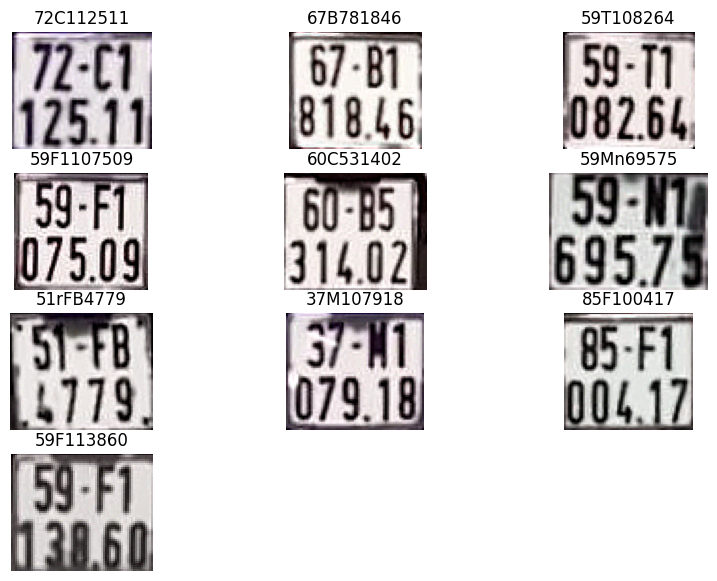

In [69]:
# show all images with predicted labels

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 4
columns = 3

for i, license_plate_file in enumerate(license_plate_files):
    path_to_license_plate = os.path.join(path_for_license_plates,license_plate_file)

    '''
    Read each license plate image file using openCV
    '''
    # img = cv2.imread(path_to_license_plate, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(path_to_license_plate)
    img = preprocess_v3(img)

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(img)
    plt.axis('off')
    plt.title(plate_lst_pp2[i])